In [17]:
import itertools

import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold

import seaborn as sb

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Считывание хороших и плохих контрактов
bad_cntr = pd.read_csv('yarobl_bad_contracts_plus.csv')
good_cntr = pd.read_csv('yaroblmz_good_contracts.csv')
data = bad_cntr.append(good_cntr)
print(data.shape)

# Сокращение количества хороших контрактов до числа имеющихся плохих
# data = good_cntr.append(bad_cntr.iloc[:good_cntr.shape[0],:])
# print(data.shape)

(11926, 15)


In [3]:
# Удаление строк, в которых есть значение NULL
data = data.dropna()

In [4]:
# Разбитие датасета на набор описывающих признаков (X) 
# и соответствущих им предсказываемых величин (у)
X = data.iloc[:,1:-1]
y = data.cntr_result.values

In [5]:
# Предобработка данных
# Медиана = 1, квадратичное отклонени = 0
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
y_train_real = np.array([])
y_test_real = np.array([])

y_train_pred = np.array([])
y_test_pred = np.array([])
y_test_pred_proba = np.zeros((0, 2))

In [7]:
svm = SVC(probability=True)

In [8]:
for train_index, test_index in KFold(n_splits=10).split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    svm.fit(X_train, y_train)
    
    y_train_real = np.concatenate((y_train_real, y_train))
    y_test_real = np.concatenate((y_test_real, y_test))
    
    y_train_pred = np.concatenate((y_train_pred, svm.predict(X_train)))
    y_test_pred = np.concatenate((y_test_pred, svm.predict(X_test)))
    y_test_pred_proba = np.concatenate((y_test_pred_proba, svm.predict_proba(X_test))) 

In [9]:
print('Точность %s на обучающей выборке' % accuracy_score(y_train_real, y_train_pred))
print('Точность %s на тестовой выборке' % accuracy_score(y_test_real, y_test_pred))
print('Потеря перекрестной энтропии %s' % log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba))

Точность 0.754379062927 на обучающей выборке
Точность 0.730568200978 на тестовой выборке
Потеря перекрестной энтропии 0.580106838843


In [10]:
print(classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')))

             precision    recall  f1-score   support

     Плохой       0.91      0.51      0.66      5926
    Хороший       0.66      0.95      0.78      5936

avg / total       0.78      0.73      0.72     11862



In [11]:
res = pd.DataFrame({'result': y_test_real}).join(
    pd.DataFrame({'proba_pred': y_test_pred_proba[:,0]}).join(
        pd.DataFrame({'pred': y_test_pred})
    )
)

In [16]:
res.corr()

,result,proba_pred,pred
result,1.000000,-0.444898,0.510943
proba_pred,-0.444898,1.000000,-0.971094
pred,0.510943,-0.971094,1.000000


In [15]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues
):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

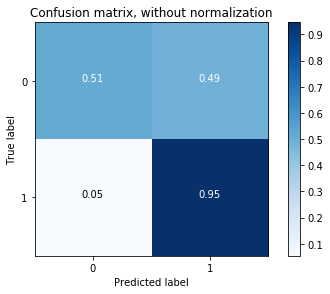

In [19]:
plot_confusion_matrix(
    confusion_matrix(y_test_real, y_test_pred), 
    classes=svm.classes_,
    normalize=True,
    title='Confusion matrix, without normalization'
)